In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

In [2]:
data_train = pd.read_csv('application_train.csv')
data_test = pd.read_csv('application_test.csv')

#from google.colab import drive
#drive.mount('/content/drive')
#data_train = pd.read_csv('/content/drive/MyDrive/application_train.csv')
#data_test = pd.read_csv('/content/drive/MyDrive/application_test.csv')

In [3]:
data_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [4]:
data_train.shape

(307511, 122)

In [5]:
data_test.shape

(48744, 121)

### Exploration Data Analysis

In [6]:
data_train.duplicated().sum()

0

In [7]:
data_test.duplicated().sum()

0

In [8]:
missval=data_train.isnull().sum()*100/data_train.shape[0]
missval[missval>0].sort_values(ascending=False)

COMMONAREA_MEDI                 69.872297
COMMONAREA_AVG                  69.872297
COMMONAREA_MODE                 69.872297
NONLIVINGAPARTMENTS_MEDI        69.432963
NONLIVINGAPARTMENTS_MODE        69.432963
NONLIVINGAPARTMENTS_AVG         69.432963
FONDKAPREMONT_MODE              68.386172
LIVINGAPARTMENTS_MODE           68.354953
LIVINGAPARTMENTS_MEDI           68.354953
LIVINGAPARTMENTS_AVG            68.354953
FLOORSMIN_MODE                  67.848630
FLOORSMIN_MEDI                  67.848630
FLOORSMIN_AVG                   67.848630
YEARS_BUILD_MODE                66.497784
YEARS_BUILD_MEDI                66.497784
YEARS_BUILD_AVG                 66.497784
OWN_CAR_AGE                     65.990810
LANDAREA_AVG                    59.376738
LANDAREA_MEDI                   59.376738
LANDAREA_MODE                   59.376738
BASEMENTAREA_MEDI               58.515956
BASEMENTAREA_AVG                58.515956
BASEMENTAREA_MODE               58.515956
EXT_SOURCE_1                    56

In [9]:
high_missval=pd.Series(missval[missval>25])
#high_missval.sort_values(ascending=False)

In [10]:
col_to_drop=high_missval.index.to_list()
col_to_drop

['OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'EXT_SOURCE_1',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MO

In [11]:
data_train.drop(columns=col_to_drop,inplace=True)
data_train.shape

(307511, 72)

In [12]:
data_test.drop(columns=col_to_drop,inplace=True)
data_test.shape

(48744, 71)

In [13]:
data_train.select_dtypes(include='object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

In [14]:
data_train.drop(columns='ORGANIZATION_TYPE', inplace=True)

In [15]:
data_test.drop(columns='ORGANIZATION_TYPE', inplace=True)

In [16]:
data_train.nunique() [data_train.nunique()==1].sort_values()

Series([], dtype: int64)

In [17]:
kat = [var for var in data_train.columns if data_train[var].dtype=='object' and (var!='TARGET' and var!='SK_ID_CURR')]
num = [var for var in data_train.columns if data_train[var].dtype!='object' and (var!='TARGET' and var!='SK_ID_CURR')]

### Numerical Features

Imputing missing values

In [18]:
data_train[num].isnull().sum().sort_values(ascending=False)

EXT_SOURCE_3                   60965
AMT_REQ_CREDIT_BUREAU_YEAR     41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_HOUR     41519
DEF_60_CNT_SOCIAL_CIRCLE        1021
OBS_60_CNT_SOCIAL_CIRCLE        1021
OBS_30_CNT_SOCIAL_CIRCLE        1021
DEF_30_CNT_SOCIAL_CIRCLE        1021
EXT_SOURCE_2                     660
AMT_GOODS_PRICE                  278
AMT_ANNUITY                       12
CNT_FAM_MEMBERS                    2
DAYS_LAST_PHONE_CHANGE             1
FLAG_EMP_PHONE                     0
FLAG_DOCUMENT_15                   0
FLAG_DOCUMENT_8                    0
FLAG_DOCUMENT_9                    0
FLAG_DOCUMENT_10                   0
FLAG_DOCUMENT_11                   0
FLAG_DOCUMENT_12                   0
FLAG_DOCUMENT_13                   0
FLAG_DOCUMENT_14                   0
FLAG_DOCUMENT_17                   0
FLAG_DOCUMENT_16                   0
F

In [19]:
missval_num=[var for var in data_train[num] if data_train[var].isnull().sum()>0]
missval_num

['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [20]:
# buat dataframe dummy
cp_data=pd.DataFrame(columns=['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_2', 'OBS_60_CNT_SOCIAL_CIRCLE'], data=data_train[['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_2', 'OBS_60_CNT_SOCIAL_CIRCLE']].values)
cp_data.head()

,AMT_ANNUITY,AMT_GOODS_PRICE,EXT_SOURCE_2,OBS_60_CNT_SOCIAL_CIRCLE
0,24700.5,351000.0,0.262949,2.0
1,35698.5,1129500.0,0.622246,1.0
2,6750.0,135000.0,0.555912,0.0
3,29686.5,297000.0,0.650442,2.0
4,21865.5,513000.0,0.322738,0.0


In [21]:
# Checking variance of 4 variables for sampling : AMT_ANNUITY, AMT_GOODS_PRICE, EXT_SOURCE_2, OBS_60_CNT_SOCIAL_CIRCLE

mean1=cp_data['AMT_ANNUITY'].mean()
median1=cp_data['AMT_ANNUITY'].median()

mean2=cp_data['AMT_GOODS_PRICE'].mean()
median2=cp_data['AMT_GOODS_PRICE'].median()

mean3=cp_data['EXT_SOURCE_2'].mean()
median3=cp_data['EXT_SOURCE_2'].median()

mean4=cp_data['OBS_60_CNT_SOCIAL_CIRCLE'].mean()
median4=cp_data['OBS_60_CNT_SOCIAL_CIRCLE'].median()

In [22]:
cp_data['mean_1']=cp_data['AMT_ANNUITY'].fillna(mean1)
cp_data['median_1']=cp_data['AMT_ANNUITY'].fillna(median1)

cp_data['mean_2']=cp_data['AMT_GOODS_PRICE'].fillna(mean2)
cp_data['median_2']=cp_data['AMT_GOODS_PRICE'].fillna(median2)

cp_data['mean_3']=cp_data['EXT_SOURCE_2'].fillna(mean3)
cp_data['median_3']=cp_data['EXT_SOURCE_2'].fillna(median3)

cp_data['mean_4']=cp_data['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(mean4)
cp_data['median_4']=cp_data['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(median4)

In [23]:
print('Original AMT_ANNUITY variance : ',cp_data['AMT_ANNUITY'].var())
print('Variance mean_1 after imputation : ',cp_data['mean_1'].var())
print('Variance median_1 after imputation : ',cp_data['median_1'].var())
print('')
print('Original AMT_GOODS_PRICE variance : ',cp_data['AMT_GOODS_PRICE'].var())
print('Variance mean_2 after imputation : ',cp_data['mean_2'].var())
print('Variance median_2 after imputation : ',cp_data['median_2'].var())
print('')
print('Original EXT_SOURCE_2 variance : ',cp_data['EXT_SOURCE_2'].var())
print('Variance mean_3 after imputation : ',cp_data['mean_3'].var())
print('Variance median_3 after imputation : ',cp_data['median_3'].var())
print('')
print('Original OBS_60_CNT_SOCIAL_CIRCLE variance : ',cp_data['OBS_60_CNT_SOCIAL_CIRCLE'].var())
print('Variance mean_4 after imputation : ',cp_data['mean_4'].var())
print('Variance median_4 after imputation : ',cp_data['median_4'].var())

Original AMT_ANNUITY variance :  210068421.35962632
Variance mean_1 after imputation :  210060223.83415946
Variance median_1 after imputation :  210060413.6569049

Original AMT_GOODS_PRICE variance :  136490687205.5433
Variance mean_2 after imputation :  136367294759.62889
Variance median_2 after imputation :  136374352408.02812

Original EXT_SOURCE_2 variance :  0.0365039828228688
Variance mean_3 after imputation :  0.036425635358841336
Variance median_3 after imputation :  0.03643133076657983

Original OBS_60_CNT_SOCIAL_CIRCLE variance :  5.663463994080467
Variance mean_4 after imputation :  5.64466006335315
Variance median_4 after imputation :  5.651195211134213


In [24]:
cp_data.cov()

,AMT_ANNUITY,AMT_GOODS_PRICE,EXT_SOURCE_2,OBS_60_CNT_SOCIAL_CIRCLE,mean_1,median_1,mean_2,median_2,mean_3,median_3,mean_4,median_4
AMT_ANNUITY,2.100684e+08,4.150001e+09,348.471183,-404.207216,2.100684e+08,2.100684e+08,4.146249e+09,4.147298e+09,347.723219,347.221450,-402.864453,-382.510846
AMT_GOODS_PRICE,4.150001e+09,1.364907e+11,9841.240608,305.263245,4.149839e+09,4.149842e+09,1.364907e+11,1.364907e+11,9820.131754,9806.156154,304.292104,695.292806
EXT_SOURCE_2,3.484712e+02,9.841241e+03,0.036504,-0.008587,3.484575e+02,3.484528e+02,9.832357e+03,9.832423e+03,0.036504,0.036504,-0.008558,-0.008740
OBS_60_CNT_SOCIAL_CIRCLE,-4.042072e+02,3.052632e+02,-0.008587,5.663464,-4.041907e+02,-4.040910e+02,3.050298e+02,3.187789e+02,-0.008568,-0.008591,5.663464,5.663464
mean_1,2.100684e+08,4.149839e+09,348.457535,-404.190733,2.100602e+08,2.100602e+08,4.146087e+09,4.147136e+09,347.709650,347.207900,-402.848732,-382.495919
median_1,2.100684e+08,4.149842e+09,348.452848,-404.090968,2.100602e+08,2.100604e+08,4.146090e+09,4.147139e+09,347.704974,347.203234,-402.749298,-382.396886
mean_2,4.146249e+09,1.364907e+11,9832.356914,305.029778,4.146087e+09,4.146090e+09,1.363673e+11,1.363673e+11,9811.254005,9797.291039,304.017013,694.664236
median_2,4.147298e+09,1.364907e+11,9832.422846,318.778903,4.147136e+09,4.147139e+09,1.363673e+11,1.363744e+11,9811.319795,9797.350851,317.720488,707.994847
mean_3,3.477232e+02,9.820132e+03,0.036504,-0.008568,3.477097e+02,3.477050e+02,9.811254e+03,9.811320e+03,0.036426,0.036426,-0.008540,-0.008721
median_3,3.472214e+02,9.806156e+03,0.036504,-0.008591,3.472079e+02,3.472032e+02,9.797291e+03,9.797351e+03,0.036426,0.036431,-0.008563,-0.008745


Text(0.5, 1.0, 'Imputasi with')

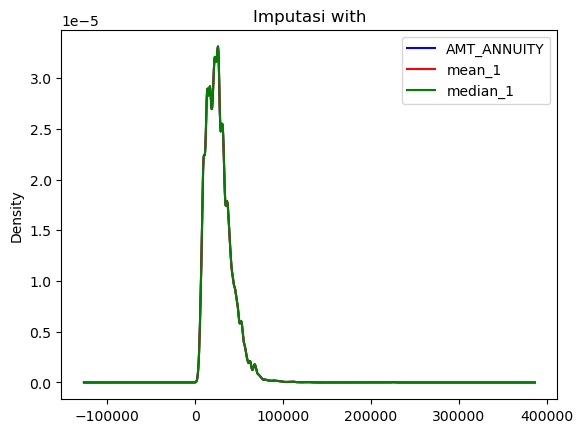

In [25]:
fig=plt.figure()
ax=fig.add_subplot(111)

cp_data['AMT_ANNUITY'].plot(kind='kde', ax=ax, color='blue')

cp_data['mean_1'].plot(kind='kde', ax=ax, color='red')

cp_data['median_1'].plot(kind='kde', ax=ax, color='green')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

plt.title('Imputasi with')

<Axes: >

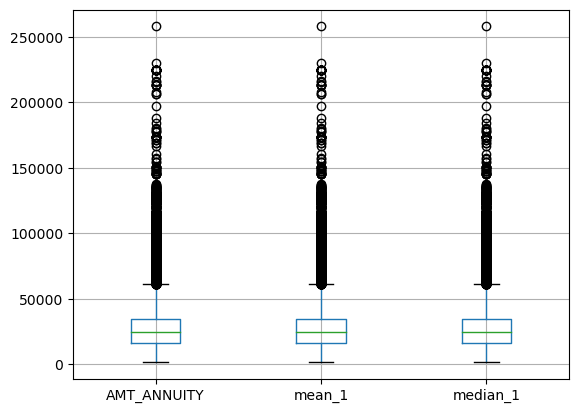

In [26]:
cp_data[['AMT_ANNUITY','mean_1','median_1']].boxplot()

Insight : Imputasi numerical values dengan mean/median tidak berpengaruh besar terhadap variansi data.

In [27]:
# imputasi dengan nilai Median
data_train[['AMT_ANNUITY','AMT_GOODS_PRICE','CNT_FAM_MEMBERS','EXT_SOURCE_2','EXT_SOURCE_3','OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']] = data_train[['AMT_ANNUITY','AMT_GOODS_PRICE','CNT_FAM_MEMBERS','EXT_SOURCE_2','EXT_SOURCE_3','OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']].fillna(data_train[['AMT_ANNUITY','AMT_GOODS_PRICE','CNT_FAM_MEMBERS','EXT_SOURCE_2','EXT_SOURCE_3','OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']].median())

In [28]:
data_train[num].isnull().sum()

CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
AMT_GOODS_PRICE                0
REGION_POPULATION_RELATIVE     0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
DAYS_REGISTRATION              0
DAYS_ID_PUBLISH                0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
CNT_FAM_MEMBERS                0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
HOUR_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
EXT_SOURCE_2                   0
EXT_SOURCE_3                   0
OBS_30_CNT_SOCIAL_CIRCLE       0
DEF_30_CNT_SOCIAL_CIRCLE       0
OBS_60_CNT

Checking Data Types

In [29]:
num_unique=data_train[num].nunique()
num_unique.sort_values(ascending=False) #num_unique[num_unique<=10].sort_values(ascending=False)

EXT_SOURCE_2                   119831
DAYS_BIRTH                      17460
DAYS_REGISTRATION               15688
AMT_ANNUITY                     13672
DAYS_EMPLOYED                   12574
DAYS_ID_PUBLISH                  6168
AMT_CREDIT                       5603
DAYS_LAST_PHONE_CHANGE           3773
AMT_INCOME_TOTAL                 2548
AMT_GOODS_PRICE                  1002
EXT_SOURCE_3                      814
REGION_POPULATION_RELATIVE         81
OBS_60_CNT_SOCIAL_CIRCLE           33
OBS_30_CNT_SOCIAL_CIRCLE           33
AMT_REQ_CREDIT_BUREAU_YEAR         25
HOUR_APPR_PROCESS_START            24
AMT_REQ_CREDIT_BUREAU_MON          24
CNT_FAM_MEMBERS                    17
CNT_CHILDREN                       15
AMT_REQ_CREDIT_BUREAU_QRT          11
DEF_30_CNT_SOCIAL_CIRCLE           10
AMT_REQ_CREDIT_BUREAU_WEEK          9
AMT_REQ_CREDIT_BUREAU_DAY           9
DEF_60_CNT_SOCIAL_CIRCLE            9
AMT_REQ_CREDIT_BUREAU_HOUR          5
REGION_RATING_CLIENT                3
REGION_RATIN

In [30]:
num_to_cat=pd.Series(num_unique[num_unique<=9]).sort_values(ascending=False)
#num_to_cat.index.to_list()

In [31]:
for col in num_to_cat.index.to_list():
  data_train[col]=data_train[col].astype(str)

In [32]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 71 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307511 non-null  float64
 10  AMT_GOODS_PRICE              307511 non-null  float64
 11  NAME_TYPE_SUITE              306219 non-null  object 
 12  NAME_INCOME_TYPE             307511 non-null  object 
 13 

In [33]:
kat_fix = [var for var in data_train.columns if data_train[var].dtype=='object' and (var!='TARGET' and var!='SK_ID_CURR')]
num_fix = [var for var in data_train.columns if data_train[var].dtype!='object' and (var!='TARGET' and var!='SK_ID_CURR')]

In [34]:
data_train[num_fix].head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,1.0,10,0.262949,0.139376,2.0,2.0,2.0,-1134.0,0.0,0.0,1.0
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,2.0,11,0.622246,0.535276,1.0,0.0,1.0,-828.0,0.0,0.0,0.0
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,1.0,9,0.555912,0.729567,0.0,0.0,0.0,-815.0,0.0,0.0,0.0
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,2.0,17,0.650442,0.535276,2.0,0.0,2.0,-617.0,0.0,0.0,1.0
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,1.0,11,0.322738,0.535276,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0


### Categorical Features

In [35]:
data_train[kat_fix].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1,1,0,1,1,0,2,2,WEDNESDAY,0,0,0,0,0,0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,1,1,0,1,1,0,1,1,MONDAY,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1,1,1,1,1,0,2,2,MONDAY,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,1,1,0,1,0,0,2,2,WEDNESDAY,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1,1,0,1,0,0,2,2,THURSDAY,0,0,0,0,1,1,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0


In [36]:
for column in kat_fix:
    print(column)
    print(data_train[column].unique())

NAME_CONTRACT_TYPE
['Cash loans' 'Revolving loans']
CODE_GENDER
['M' 'F' 'XNA']
FLAG_OWN_CAR
['N' 'Y']
FLAG_OWN_REALTY
['Y' 'N']
NAME_TYPE_SUITE
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE
['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS
['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE
['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
FLAG_MOBIL
['1' '0']
FLAG_EMP_PHONE
['1' '0']
FLAG_WORK_PHONE
['0' '1']
FLAG_CONT_MOBILE
['1' '0']
FLAG_PHONE
['1' '0']
FLAG_EMAIL
['0' '1']
REGION_RATING_CLIENT
['2' '1' '3']
REGION_RATING_CLIENT_W_CITY
['2' '1' '3']
WEEKDAY_APPR_PROCESS_START
['WEDNESD

Imputing missing values


In [37]:
missval_kat=[var for var in data_train[kat_fix] if data_train[var].isnull().sum()>0]
missval_kat

['NAME_TYPE_SUITE']

In [38]:
data_train['CODE_GENDER'].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

<Axes: xlabel='NAME_TYPE_SUITE'>

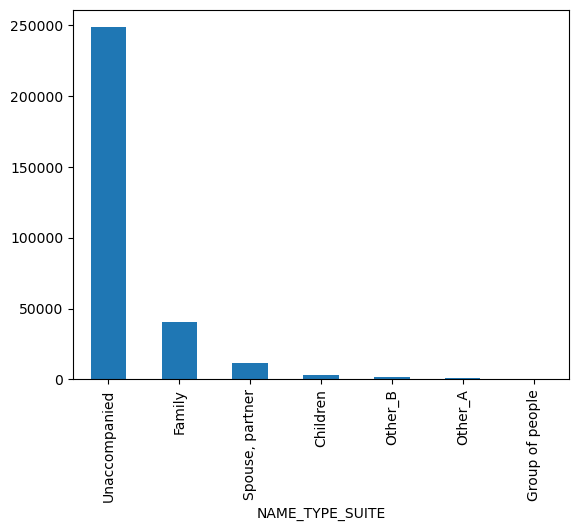

In [39]:
data_train['NAME_TYPE_SUITE'].value_counts().sort_values(ascending=False).plot.bar()

In [40]:
before_imp=data_train[data_train['NAME_TYPE_SUITE']=='Unaccompanied']['TARGET']
before_imp.value_counts()

TARGET
0    228189
1     20337
Name: count, dtype: int64

In [41]:
# imputasi dengan nilai Modus
data_train['NAME_TYPE_SUITE'].fillna('Unaccompanied',inplace=True)

In [42]:
after_imp=data_train[data_train['NAME_TYPE_SUITE']=='Unaccompanied']['TARGET']
after_imp.value_counts()

TARGET
0    229411
1     20407
Name: count, dtype: int64

Text(0.5, 1.0, 'NAME_TYPE_SUITE')

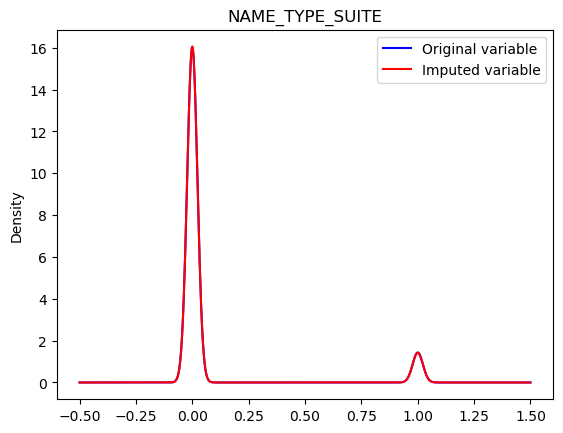

In [43]:
fig=plt.figure()
ax=fig.add_subplot(111)

before_imp.plot(kind='kde', ax=ax, color='blue')

#data_train[data_train['NAME_TYPE_SUITE']=='Unaccompanied']['TARGET'].plot(kind='kde',ax=ax,color='red')
after_imp.plot(kind='kde',ax=ax,color='red')

lines, labels = ax.get_legend_handles_labels()
labels=['Original variable','Imputed variable']
ax.legend(lines, labels, loc='best')

plt.title('NAME_TYPE_SUITE')

Insight : Imputasi categorical values dengan modus lebih cenderung dilakukan.

In [44]:
data_train[kat_fix].isnull().sum()

NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
NAME_TYPE_SUITE                0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
WEEKDAY_APPR_PROCESS_START     0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
DEF_60_CNT_SOCIAL_CIRCLE       0
FLAG_DOCUMENT_2                0
FLAG_DOCUMENT_3                0
FLAG_DOCUMENT_4                0
FLAG_DOCUMENT_5                0
FLAG_DOCUMENT_6                0
FLAG_DOCUM

### Outlier Handling

In [45]:
def cek_plot(dataset, kolom):
    fig,ax = plt.subplots(1,2, figsize=(10,5))

    # Histogram
    sns.histplot(dataset[kolom], bins=30, ax=ax[0])
    ax[0].set_title('Histogram')

    # Boxplot
    sns.boxplot(y=dataset[kolom], ax=ax[1])
    ax[1].set_title('Boxplot')

    # Judul utama
    fig.suptitle('Analisis variabel ' + str(kolom))

    # Menampilkan gambar
    plt.show()

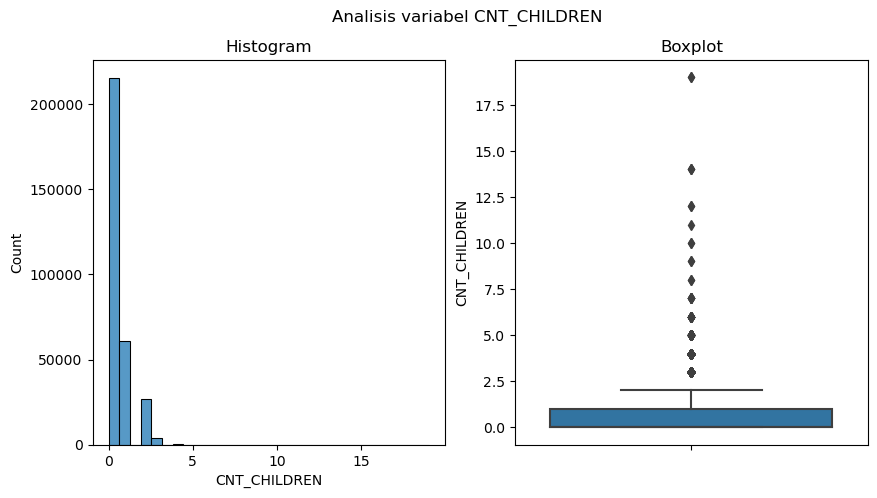

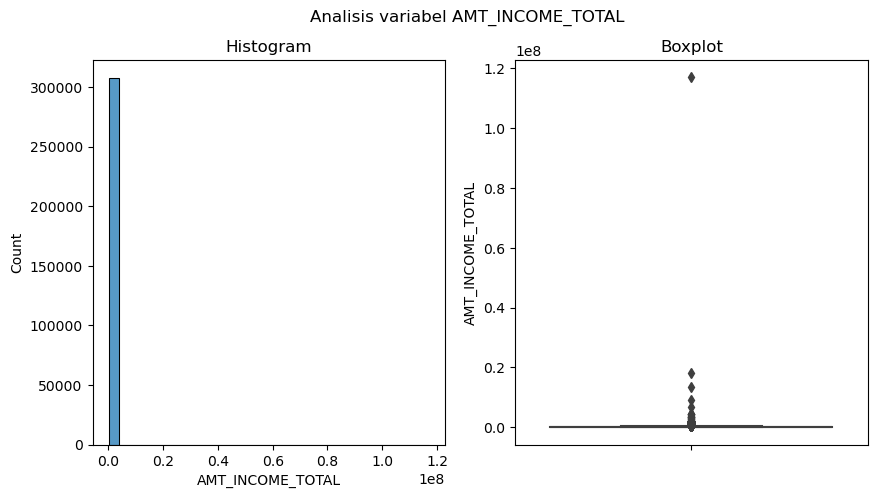

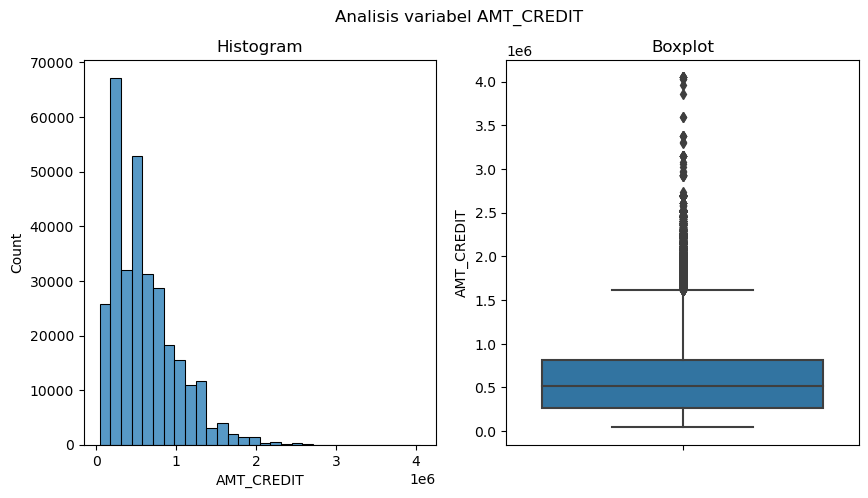

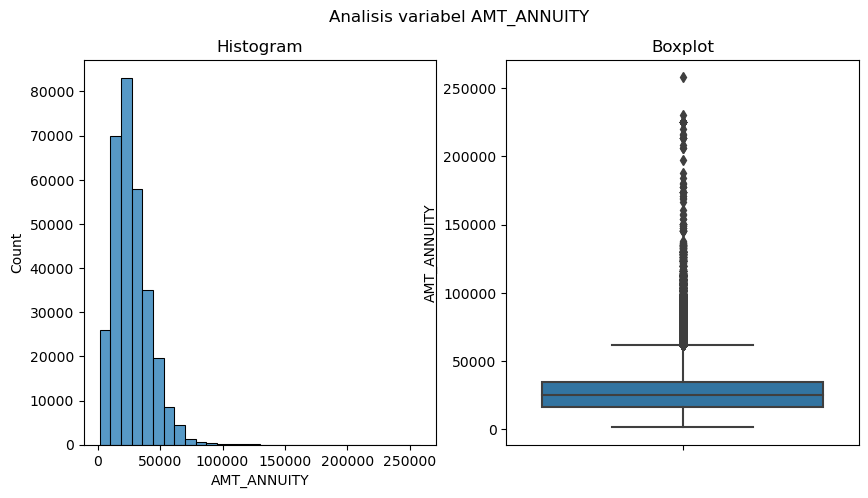

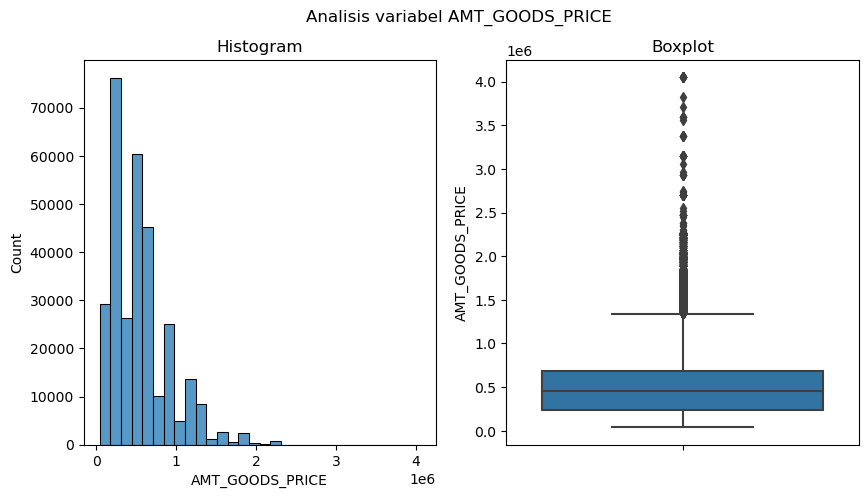

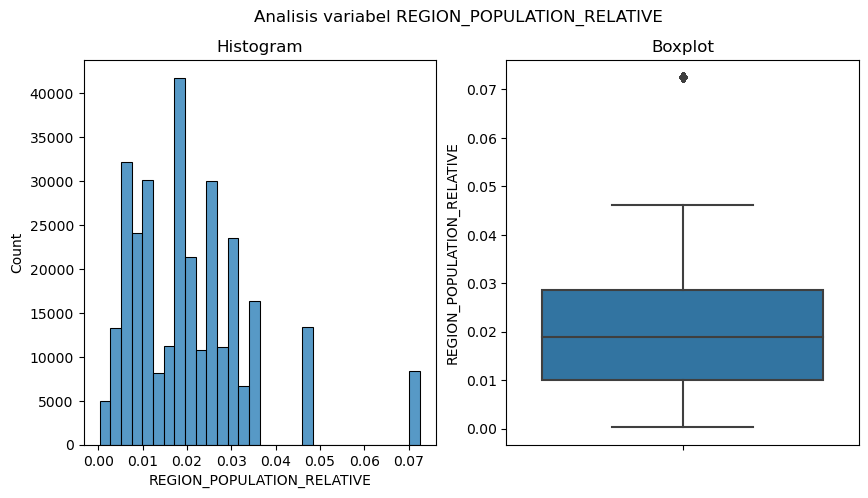

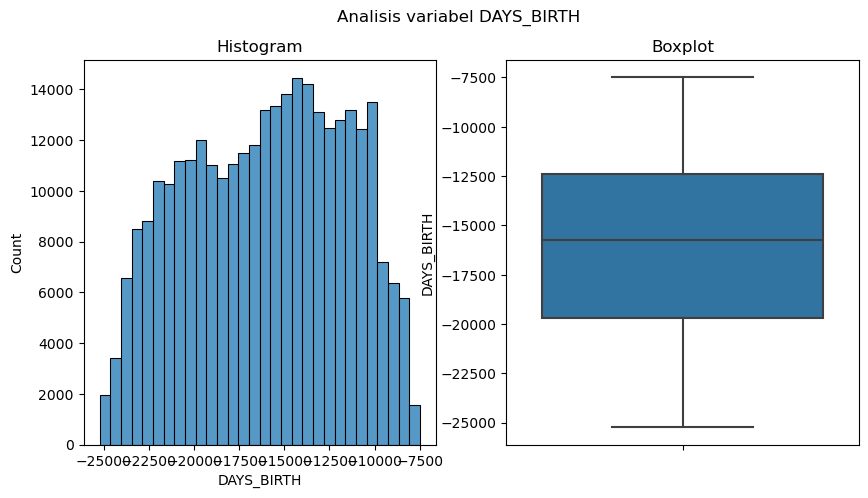

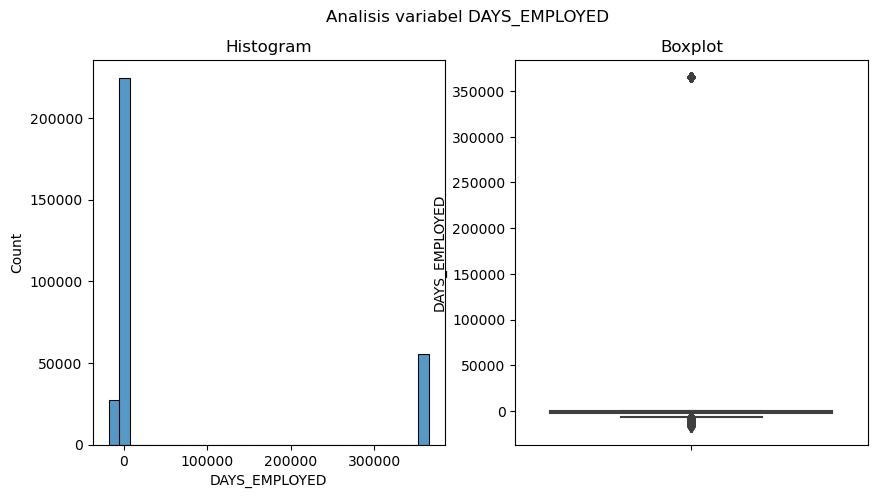

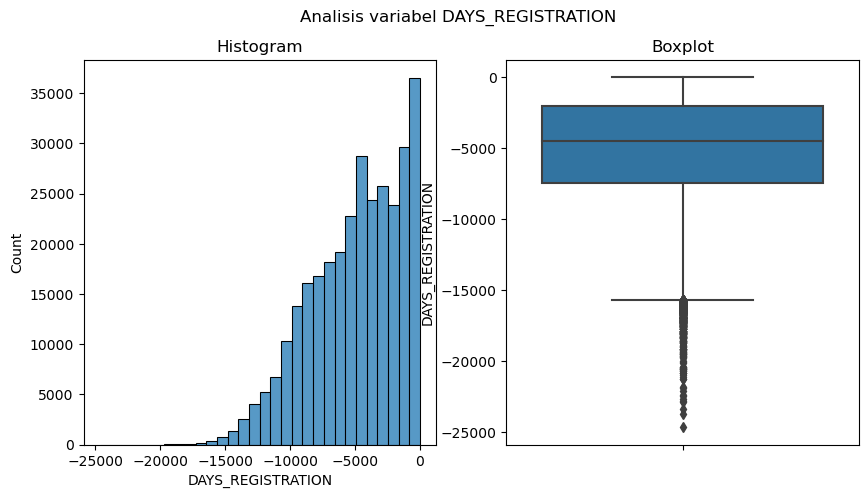

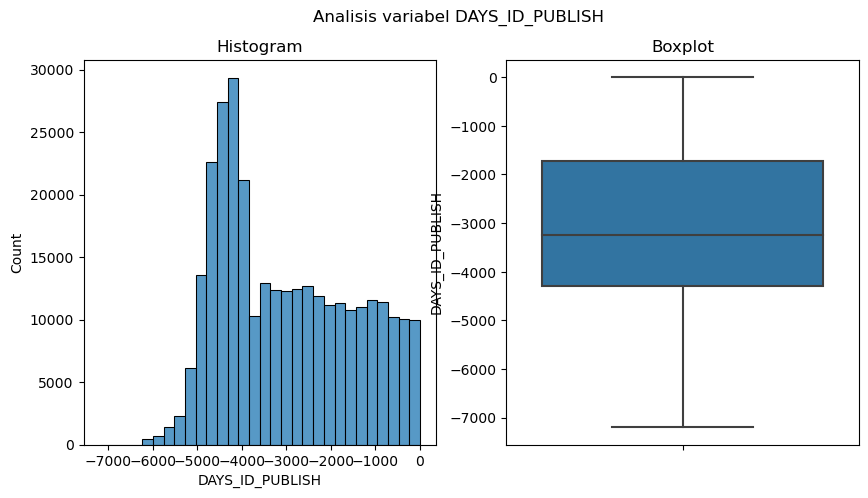

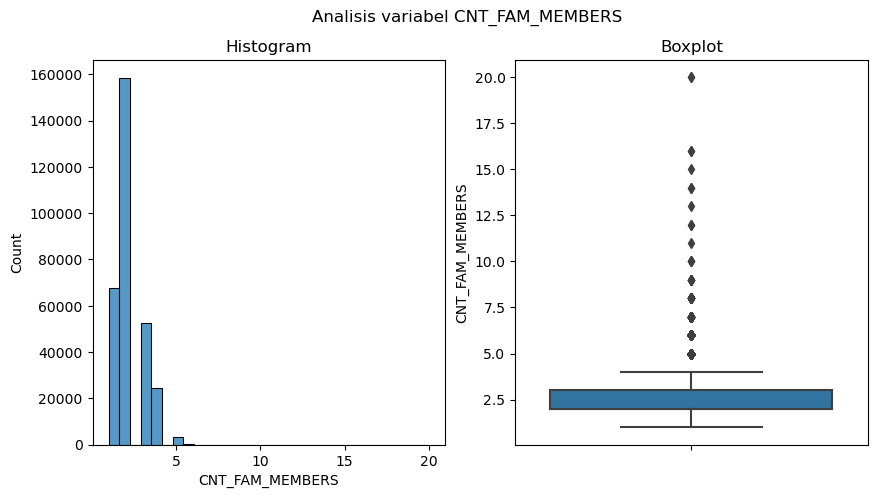

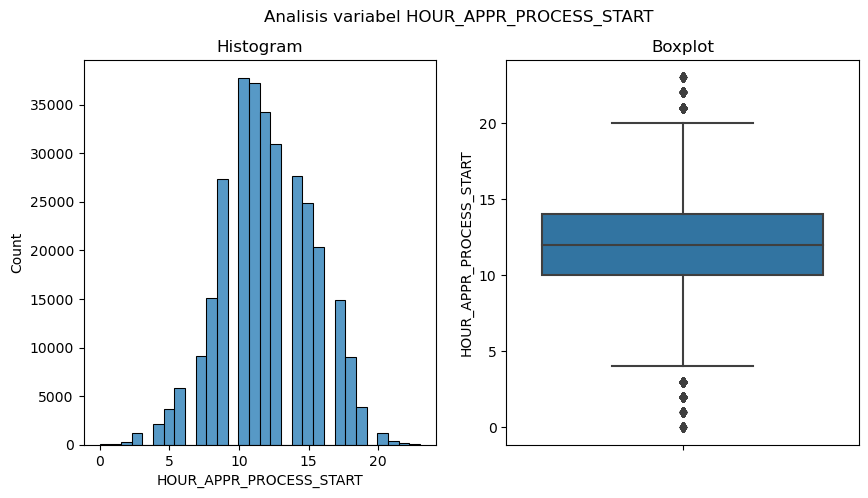

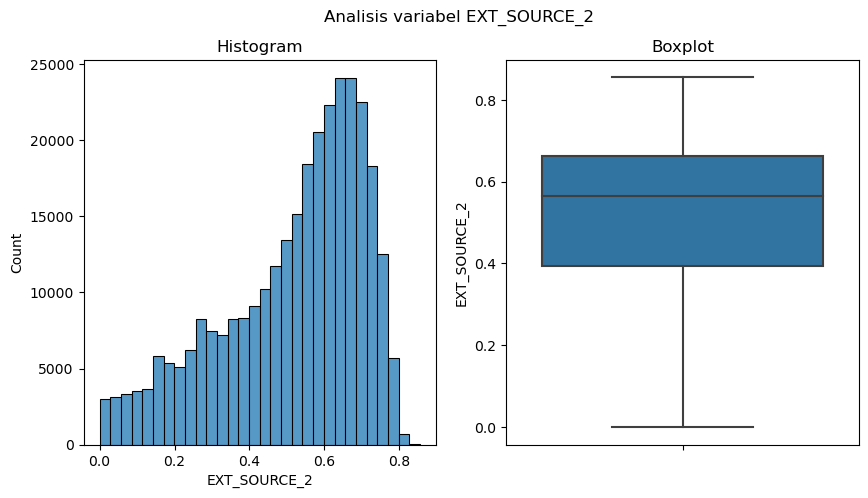

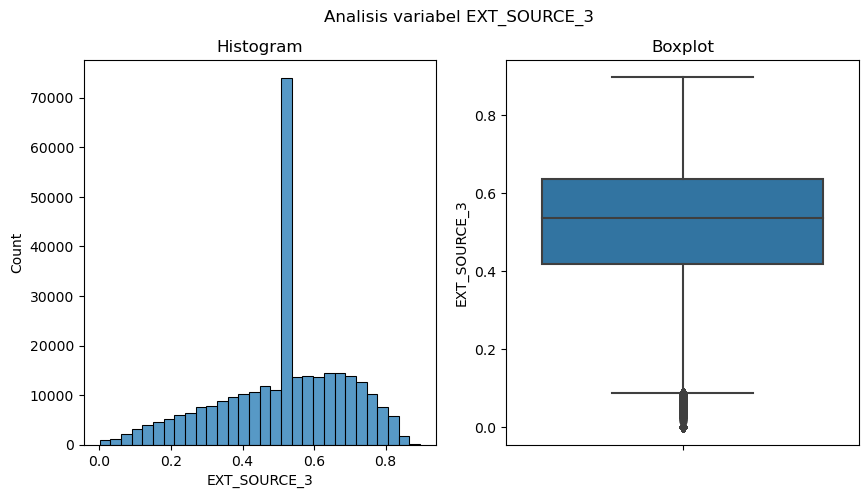

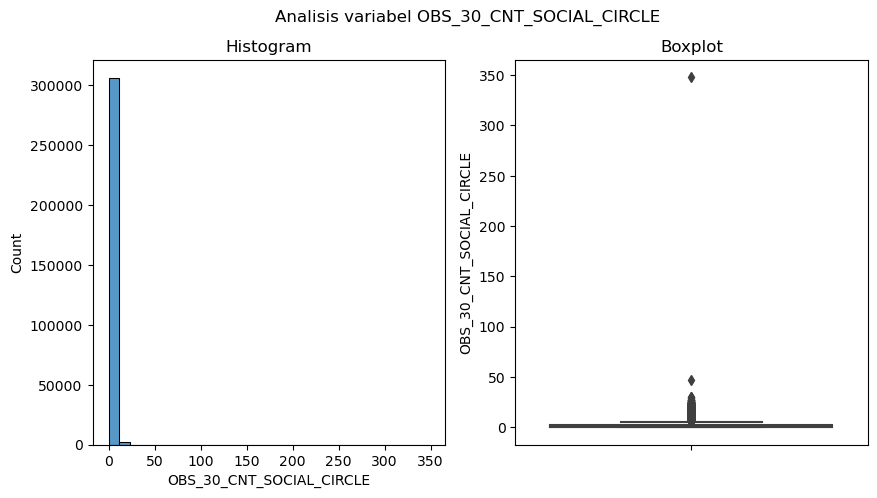

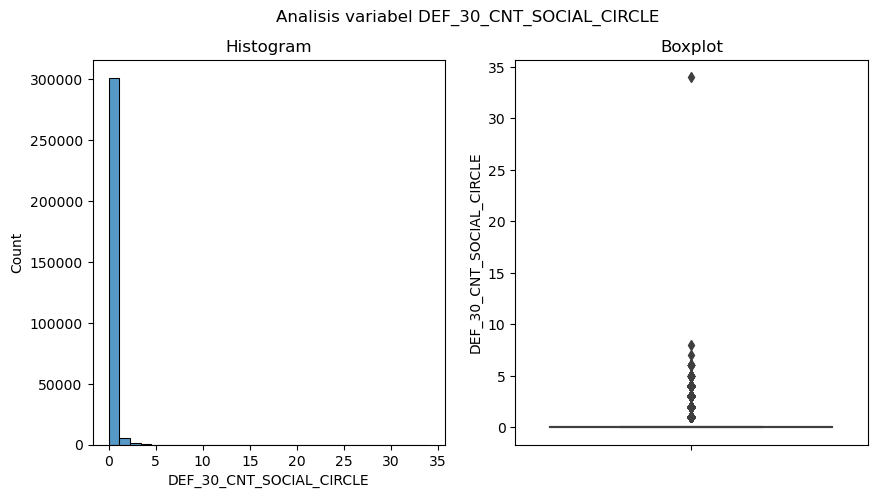

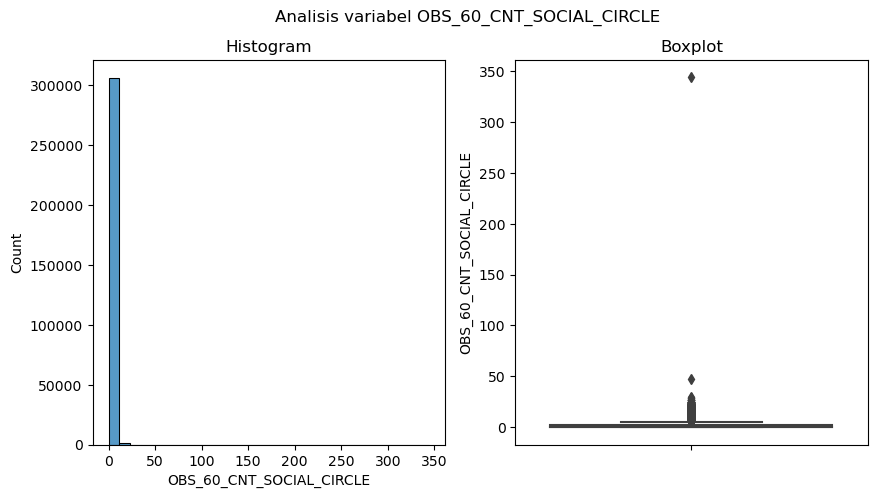

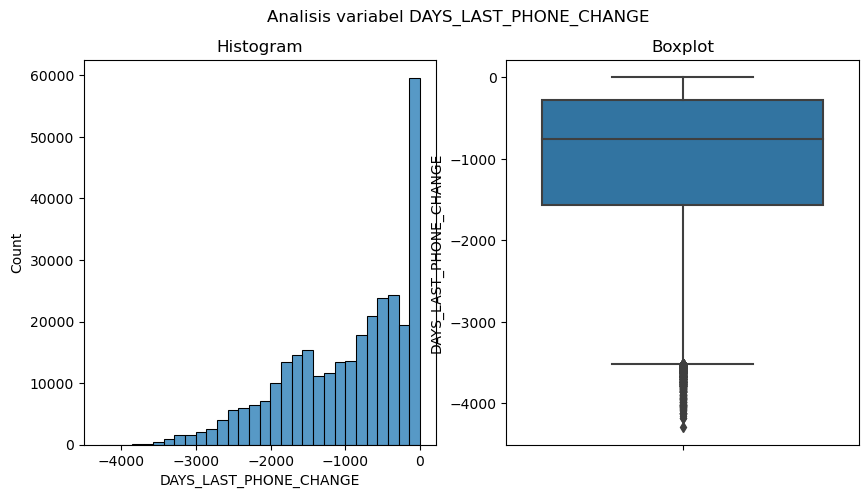

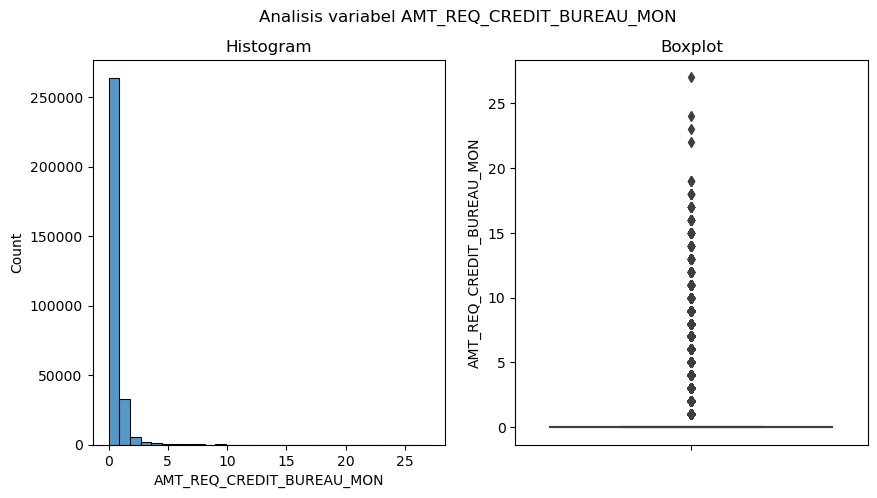

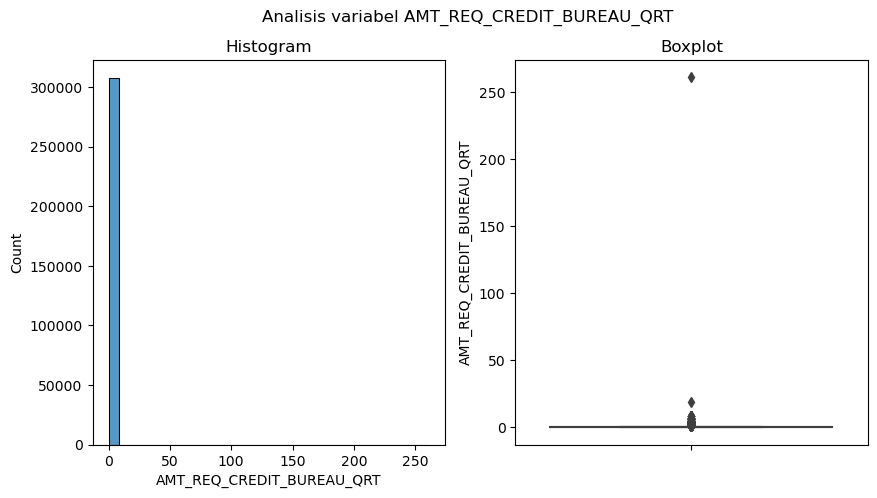

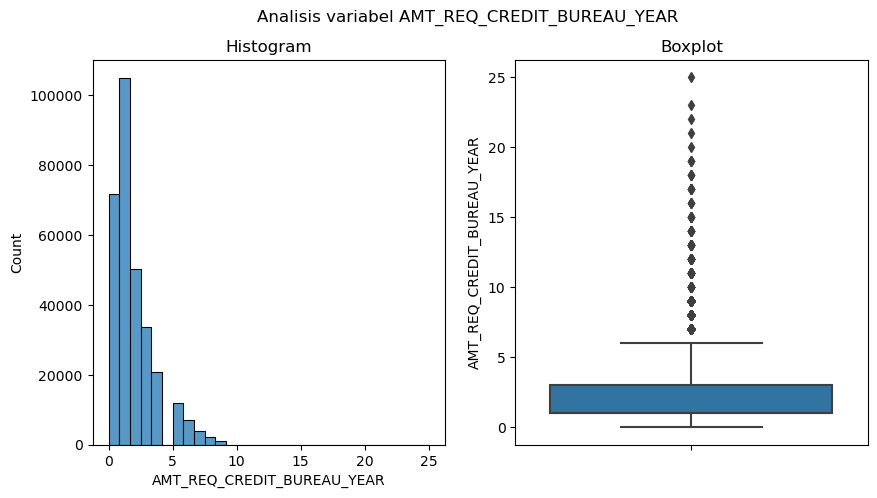

In [46]:
for i in data_train[num_fix].columns:
  cek_plot(data_train[num_fix], i)

In [47]:
#data_train[num_fix].describe()

In [48]:
# Fungsi mendeteksi normal atau skewed
def split_norm_skew_test(data):
    # Membuat data frame dengan nama kolom: feature, skewness, distribution
    global distribution_df
    distribution_df = pd.DataFrame(columns=['feature', 'skewness', 'distribution'])
    for i in range(len(data.columns)):
        if data[data.columns[i]].skew() > -0.5 and data[data.columns[i]].skew() < 0.5:
            distribution_df.loc[i] = [data.columns[i], data[data.columns[i]].skew(), 'normal']
        else:
            distribution_df.loc[i] = [data.columns[i], data[data.columns[i]].skew(), 'skewed']
    print('Membuat tabel "distribution_df"')


# Menjalankan fungsinya
split_norm_skew_test(data_train[num_fix])

Membuat tabel "distribution_df"


In [49]:
distribution_df.sort_values(by=['distribution'])

,feature,skewness,distribution
6,DAYS_BIRTH,-0.115673,normal
9,DAYS_ID_PUBLISH,0.349327,normal
11,HOUR_APPR_PROCESS_START,-0.028024,normal
0,CNT_CHILDREN,1.974604,skewed
18,AMT_REQ_CREDIT_BUREAU_MON,8.371505,skewed
17,DAYS_LAST_PHONE_CHANGE,-0.713609,skewed
16,OBS_60_CNT_SOCIAL_CIRCLE,12.075153,skewed
15,DEF_30_CNT_SOCIAL_CIRCLE,5.192572,skewed
14,OBS_30_CNT_SOCIAL_CIRCLE,12.143796,skewed
13,EXT_SOURCE_3,-0.537697,skewed


In [50]:
#!pip install feature_engine

In [51]:
from feature_engine.outliers import Winsorizer

In [52]:
data_train.drop(columns=['AMT_REQ_CREDIT_BUREAU_MON', 'DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_QRT'],axis=1,inplace=True)
data_test.drop(columns=['AMT_REQ_CREDIT_BUREAU_MON', 'DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_QRT'],axis=1,inplace=True)

In [53]:
# Membuat pengganti nilai outliers dengan batas atas dan bawah
windsoriser = Winsorizer(capping_method='iqr', # Bisa dipilih menggunakan 'iqr' atau 'gaussian'
                          tail='both', # mengganti nilai batas bawah ('left'), batas atas ('right'), atau keduanya ('both')
                          fold=1.5,
                          variables=['DAYS_ID_PUBLISH','HOUR_APPR_PROCESS_START','CNT_CHILDREN','DAYS_LAST_PHONE_CHANGE','OBS_60_CNT_SOCIAL_CIRCLE','OBS_30_CNT_SOCIAL_CIRCLE','EXT_SOURCE_3','EXT_SOURCE_2','CNT_FAM_MEMBERS','DAYS_REGISTRATION','DAYS_EMPLOYED','REGION_POPULATION_RELATIVE','AMT_GOODS_PRICE','AMT_ANNUITY','AMT_CREDIT','AMT_INCOME_TOTAL','AMT_REQ_CREDIT_BUREAU_YEAR'])

# Melakukan fitting ke variabel df
windsoriser.fit(data_train)

Winsorizer(capping_method='iqr', fold=1.5, tail='both',
           variables=['DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START',
                      'CNT_CHILDREN', 'DAYS_LAST_PHONE_CHANGE',
                      'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE',
                      'EXT_SOURCE_3', 'EXT_SOURCE_2', 'CNT_FAM_MEMBERS',
                      'DAYS_REGISTRATION', 'DAYS_EMPLOYED',
                      'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE',
                      'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_INCOME_TOTAL',
                      'AMT_REQ_CREDIT_BUREAU_YEAR'])

In [54]:
train_new = windsoriser.transform(data_train)

In [55]:
num_new=['DAYS_ID_PUBLISH','HOUR_APPR_PROCESS_START','CNT_CHILDREN','DAYS_LAST_PHONE_CHANGE','OBS_60_CNT_SOCIAL_CIRCLE','OBS_30_CNT_SOCIAL_CIRCLE','EXT_SOURCE_3','EXT_SOURCE_2','CNT_FAM_MEMBERS','DAYS_REGISTRATION','DAYS_EMPLOYED','REGION_POPULATION_RELATIVE','AMT_GOODS_PRICE','AMT_ANNUITY','AMT_CREDIT','AMT_INCOME_TOTAL','AMT_REQ_CREDIT_BUREAU_YEAR']

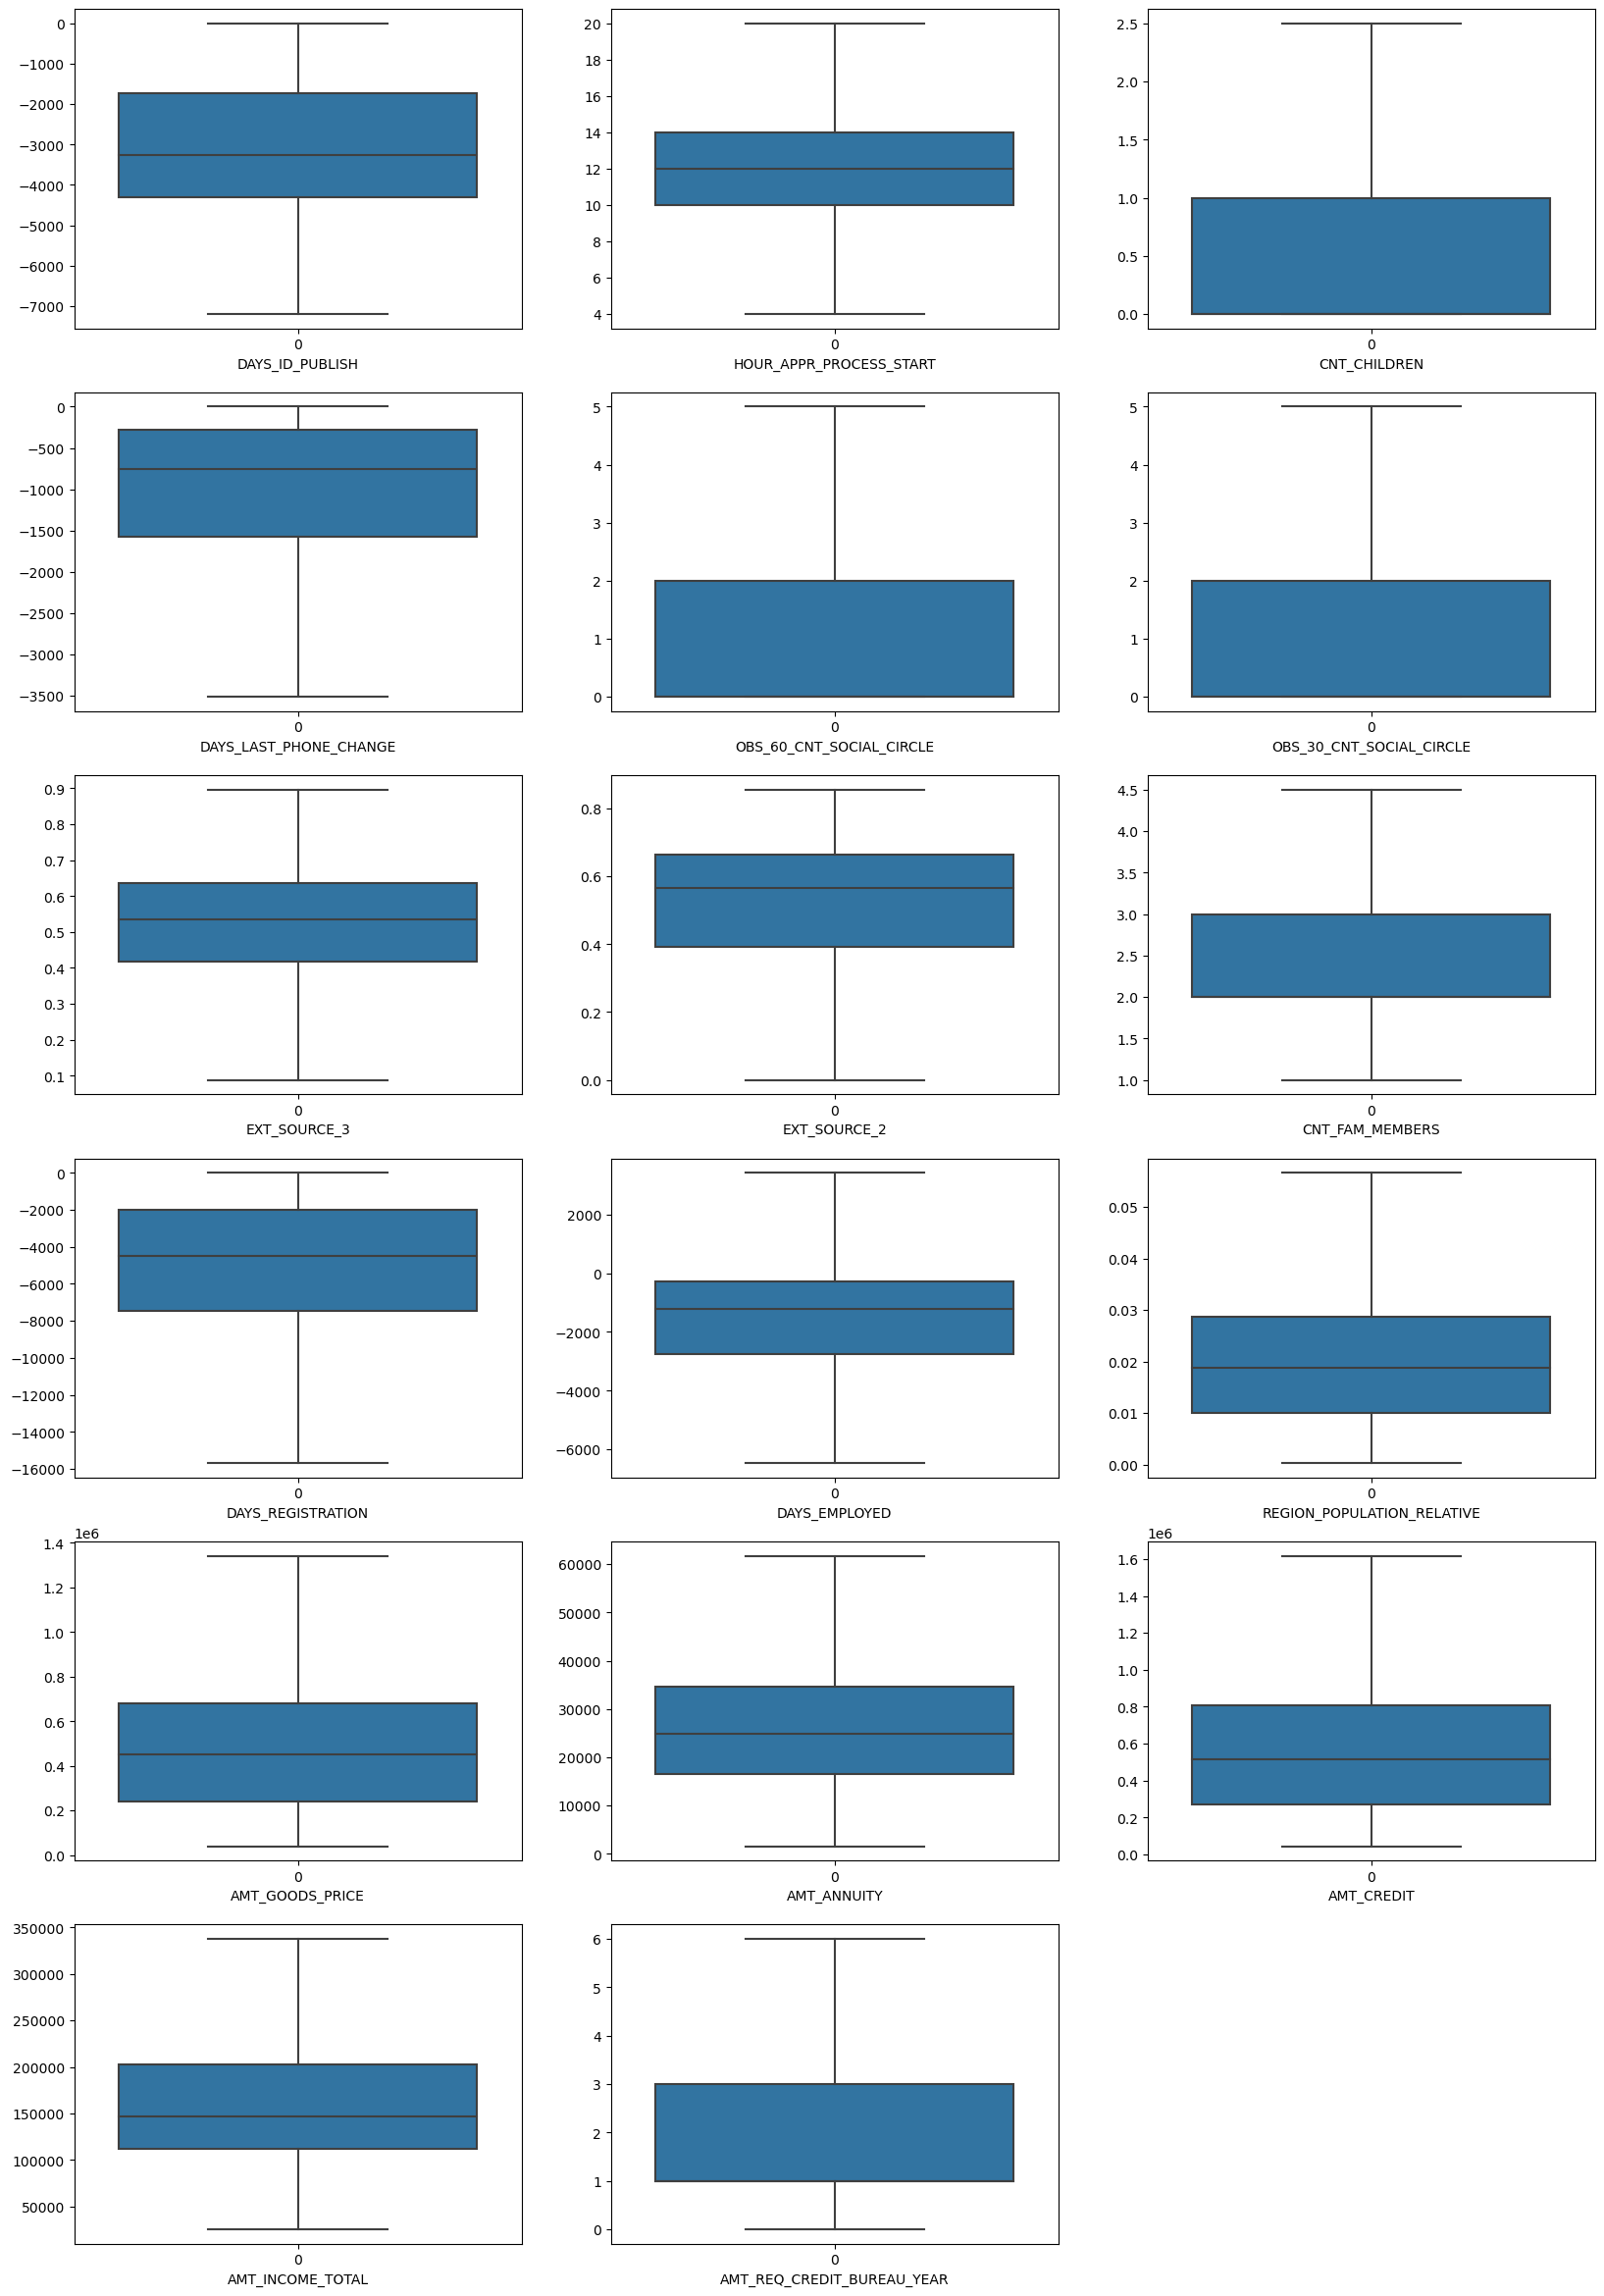

In [56]:
#for i in train_new[num_new].columns:
#  cek_plot(train_new[num_new], i)

#boxplot on numerical features to find outliers
plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for i in num_new:
    ax = plt.subplot(12,3,plotnumber)
    sns.boxplot(train_new[i])
    plt.xlabel(i)
    plotnumber+=1
plt.show()

In [57]:
train_new.shape

(307511, 68)

In [58]:
data_test.shape

(48744, 67)

### Checking Imbalance Label

TARGET
0    91.927118
1     8.072882
Name: count, dtype: float64


<Axes: title={'center': 'TARGET %'}, xlabel='TARGET', ylabel='count'>

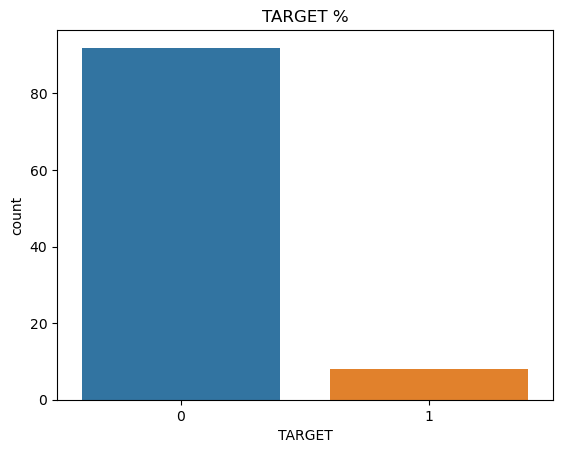

In [59]:
results = (train_new['TARGET'].value_counts() / len(train_new['TARGET']))*100
print(results)
plt.title('TARGET %')
sns.barplot(x=train_new['TARGET'].value_counts().index,y=results)

Insight : Dataset is imbalance

### One Hot Encoding

In [60]:
print(kat)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START']


In [61]:
ohe = OneHotEncoder(drop='first',sparse_output=False,handle_unknown='ignore').set_output(transform='pandas')
ohe_kat = ohe.fit_transform(train_new[['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START']])
ohe_test = ohe.fit_transform(data_test[['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START']])

In [62]:
ohe_kat.head()

,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [63]:
ohe_test.head()

,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
datatrain_new = pd.concat([train_new, ohe_kat], axis=1)
datatest_new = pd.concat([data_test, ohe_test], axis=1)

In [65]:
datatrain_new = datatrain_new.drop(columns=kat, axis=1)
datatest_new = datatest_new.drop(columns=kat, axis=1)

In [66]:
datatrain_new.shape

(307511, 96)

In [67]:
datatest_new.shape

(48744, 93)

In [68]:
obj = [var for var in datatrain_new.columns if datatrain_new[var].dtype=='object']

In [69]:
for col in obj:
    if (datatrain_new[col].nunique()==2 or datatest_new[col].nunique()==2):
        datatrain_new[col]=datatrain_new[col].astype(str).astype(int)
        datatest_new[col]=datatest_new[col].astype(str).astype(int)  
    else:
        datatrain_new[col]=datatrain_new[col].astype(str).astype(float)
        datatest_new[col]=datatest_new[col].astype(str).astype(float)

In [70]:
#datatest_new.dtypes

### Deklarasi Variable

In [71]:
X = datatrain_new.drop(['TARGET','SK_ID_CURR'],axis=1)
y = datatrain_new['TARGET']

### Over Sampling

In [72]:
#!pip install -U imbalanced-learn

In [73]:
# Mengimpor library imblearn
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(
    sampling_strategy= 'auto', # sampling untuk kategori minoritas
    random_state= 123,  # untuk replikasi
)

# Fitting ke X dan y
X_res, y_res = ros.fit_resample(X,y)

#from imblearn.over_sampling import SMOTE
#X_res, y_res= SMOTE(random_state=42).fit_resample(X,y)

<Axes: >

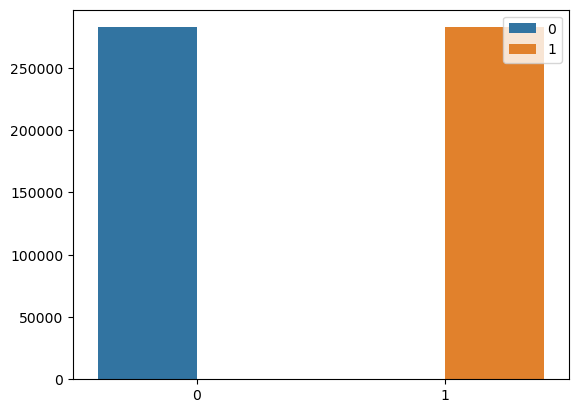

In [74]:
idx, c = np.unique(y_res, return_counts=True)
sns.barplot(x=idx, y=c, hue=idx)

In [75]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    X_res,
    y_res,
    test_size = 0.2,
    random_state = 0)

# Reset indeks dengan looping
for i in [X_train, X_test, y_train, y_test]:
    i.reset_index(drop=True, inplace=True)

# Melihat dimensi training set dan test set
print(X_train.shape, X_test.shape)

(452297, 94) (113075, 94)


### Feature Selection

In [76]:
from sklearn.feature_selection import mutual_info_classif

In [77]:
mutual_info= mutual_info_classif(X_train, y_train)
#mutual_info

In [78]:
mutual_info= pd.Series(mutual_info)
mutual_info.index= X_train.columns
mutual_info.sort_values(ascending=False)

EXT_SOURCE_2                                         0.382095
DAYS_BIRTH                                           0.124379
AMT_ANNUITY                                          0.098067
DAYS_REGISTRATION                                    0.092460
FLAG_MOBIL                                           0.057865
DAYS_EMPLOYED                                        0.055489
NAME_EDUCATION_TYPE_Secondary / secondary special    0.053895
FLAG_DOCUMENT_3                                      0.051968
FLAG_EMP_PHONE                                       0.050047
FLAG_CONT_MOBILE                                     0.049953
NAME_FAMILY_STATUS_Married                           0.048072
FLAG_OWN_REALTY_Y                                    0.048001
NAME_TYPE_SUITE_Unaccompanied                        0.047764
NAME_INCOME_TYPE_Working                             0.046691
EXT_SOURCE_3                                         0.046578
NAME_HOUSING_TYPE_House / apartment                  0.045417
AMT_CRED

<Axes: >

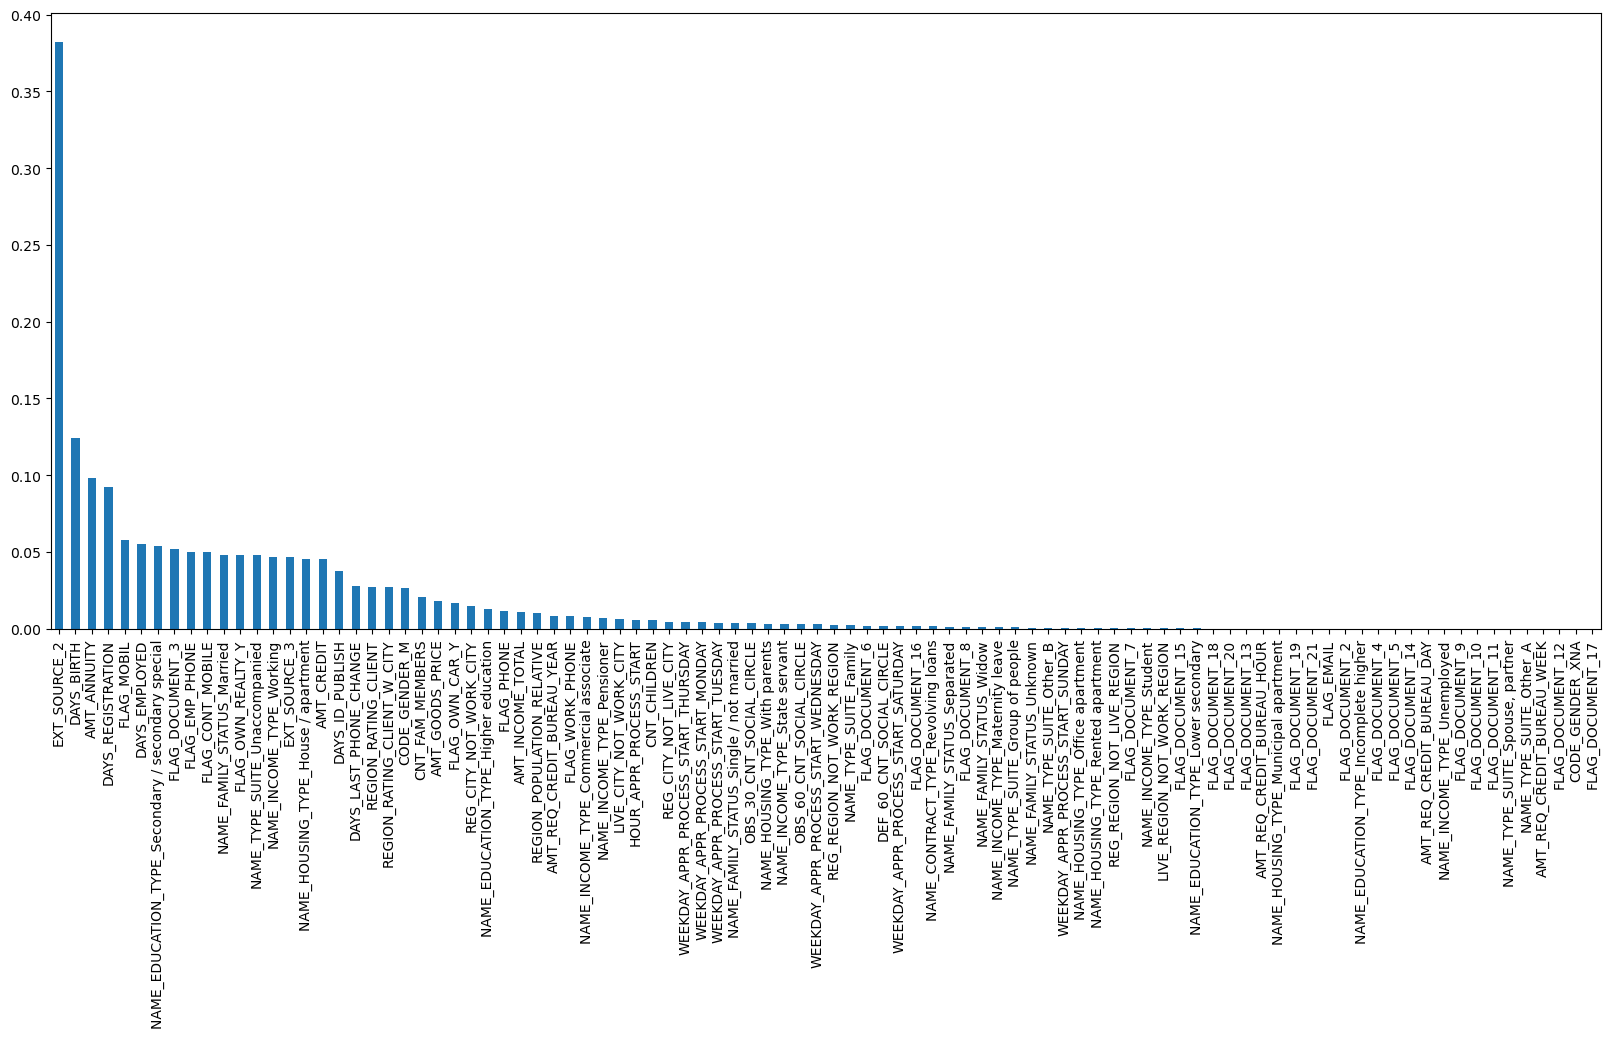

In [79]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20,8))

In [80]:
best_cols= SelectKBest(mutual_info_classif, k=20)
best_cols.fit(X_train, y_train)
X_train.columns[best_cols.get_support()]

Index(['AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_CONT_MOBILE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'CODE_GENDER_M',
       'FLAG_OWN_REALTY_Y', 'NAME_TYPE_SUITE_Unaccompanied',
       'NAME_INCOME_TYPE_Working',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_Married', 'NAME_HOUSING_TYPE_House / apartment'],
      dtype='object')

In [81]:
X_train_new = pd.DataFrame(X_train, columns=X_train.columns[best_cols.get_support()])
X_train_new.head()

,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,CODE_GENDER_M,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_HOUSING_TYPE_House / apartment
0,582804.0,23868.0,-9723,-254.0,-4329.0,-2407,1,1,1,0.703942,0.212756,-234.0,0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
1,1594395.0,52690.5,-11066,-917.0,-5118.0,-3689,1,1,1,0.319939,0.420611,-1680.0,1,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2,808650.0,23773.5,-21547,-1120.0,-13326.0,-4689,1,1,1,0.715616,0.832785,-1704.0,1,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,477621.0,32049.0,-10866,-1051.0,-4876.0,-2387,1,1,1,0.648690,0.303146,-70.0,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,495000.0,25627.5,-9245,-834.0,-1612.0,-1910,1,1,1,0.601796,0.535276,-1.0,1,0.0,0.0,1.0,0.0,1.0,1.0,1.0


In [82]:
X_test_new = pd.DataFrame(X_test, columns=X_test.columns[best_cols.get_support()])
X_test_new.head()

,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,CODE_GENDER_M,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_HOUSING_TYPE_House / apartment
0,566055.0,22063.5,-10262,-2358.0,-3364.0,-1683,1,1,1,0.601136,0.812823,-1781.0,1,1.0,1.0,1.0,0.0,1.0,0.0,1.0
1,1245636.0,44869.5,-9241,-598.0,-4034.0,-1753,1,1,1,0.728495,0.535276,-368.0,1,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2,1560726.0,41301.0,-22199,-2037.0,-6236.0,-4529,1,1,1,0.172547,0.687933,-413.0,1,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,360000.0,17640.0,-14495,-1198.0,-4105.0,-4105,1,1,1,0.201584,0.535276,-361.0,1,0.0,1.0,1.0,1.0,1.0,0.0,1.0
4,640080.0,29970.0,-10852,-415.0,-10806.0,-1393,1,1,1,0.782644,0.200926,-303.0,1,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [83]:
test_id=pd.DataFrame(datatest_new,columns=['SK_ID_CURR'])

In [88]:
test_cols = pd.DataFrame(datatest_new, columns=['AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_CONT_MOBILE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'CODE_GENDER_M',
       'FLAG_OWN_REALTY_Y', 'NAME_TYPE_SUITE_Unaccompanied',
       'NAME_INCOME_TYPE_Working',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_Married', 'NAME_HOUSING_TYPE_House / apartment'])
test_cols.head()

,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,CODE_GENDER_M,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_HOUSING_TYPE_House / apartment
0,568800.0,20560.5,-19241,-2329,-5170.0,-812,1,1,1,0.789654,0.159520,-1740.0,1,0.0,1.0,1.0,1.0,0.0,1.0,1.0
1,222768.0,17370.0,-18064,-4469,-9118.0,-1623,1,1,1,0.291656,0.432962,0.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,663264.0,69777.0,-20038,-4458,-2175.0,-3503,1,1,1,0.699787,0.610991,-856.0,0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
3,1575000.0,49018.5,-13976,-1866,-2000.0,-4208,1,1,1,0.509677,0.612704,-1805.0,1,0.0,1.0,1.0,1.0,1.0,1.0,1.0
4,625500.0,32067.0,-13040,-2191,-4000.0,-4262,1,1,1,0.425687,NaN,-821.0,1,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [89]:
test_cols.shape

(48744, 20)

### Feature Scaling

In [90]:
mm_scaler= MinMaxScaler()
mm_scaler.fit(X_train_new)
X_train_new_scaled=mm_scaler.transform(X_train_new)
X_test_new_scaled=mm_scaler.transform(X_test_new)

In [91]:
data_test_new_scaled=mm_scaler.transform(test_cols)

In [92]:
X_train_new_scaled= pd.DataFrame(X_train_new_scaled, columns=X_train_new.columns)
X_test_new_scaled= pd.DataFrame(X_test_new_scaled, columns=X_test_new.columns)

In [93]:
data_test_new_scaled= pd.DataFrame(data_test_new_scaled, columns=test_cols.columns)

In [94]:
np.round(X_train_new.describe(),1)

,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,CODE_GENDER_M,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_HOUSING_TYPE_House / apartment
count,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0
mean,575636.7,26621.8,-15514.3,-1166.0,-4755.7,-2876.8,1.0,0.8,1.0,0.5,0.5,-893.0,0.7,0.4,0.7,0.8,0.6,0.7,0.6,0.9
std,360183.1,12721.0,4321.0,2519.8,3424.5,1519.1,0.0,0.4,0.0,0.2,0.2,799.4,0.4,0.5,0.5,0.4,0.5,0.4,0.5,0.3
min,45000.0,1615.5,-25229.0,-6466.5,-15683.8,-7197.0,0.0,0.0,0.0,0.0,0.1,-3514.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,277969.5,16875.0,-19011.0,-2475.0,-7113.0,-4224.0,1.0,1.0,1.0,0.3,0.3,-1485.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
50%,508495.5,25078.5,-15071.0,-1119.0,-4296.0,-3045.0,1.0,1.0,1.0,0.5,0.5,-677.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,781920.0,33889.5,-11884.0,-337.0,-1853.0,-1559.0,1.0,1.0,1.0,0.6,0.6,-238.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,1616625.0,61704.0,-7489.0,3417.5,0.0,0.0,1.0,1.0,1.0,0.9,0.9,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [95]:
np.round(X_train_new_scaled.describe(),1)

,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,CODE_GENDER_M,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_HOUSING_TYPE_House / apartment
count,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0,452297.0
mean,0.3,0.4,0.5,0.5,0.7,0.6,1.0,0.8,1.0,0.5,0.5,0.7,0.7,0.4,0.7,0.8,0.6,0.7,0.6,0.9
std,0.2,0.2,0.2,0.3,0.2,0.2,0.0,0.4,0.0,0.2,0.2,0.2,0.4,0.5,0.5,0.4,0.5,0.4,0.5,0.3
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.1,0.3,0.4,0.4,0.5,0.4,1.0,1.0,1.0,0.4,0.3,0.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
50%,0.3,0.4,0.6,0.5,0.7,0.6,1.0,1.0,1.0,0.6,0.6,0.8,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,0.5,0.5,0.8,0.6,0.9,0.8,1.0,1.0,1.0,0.7,0.6,0.9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


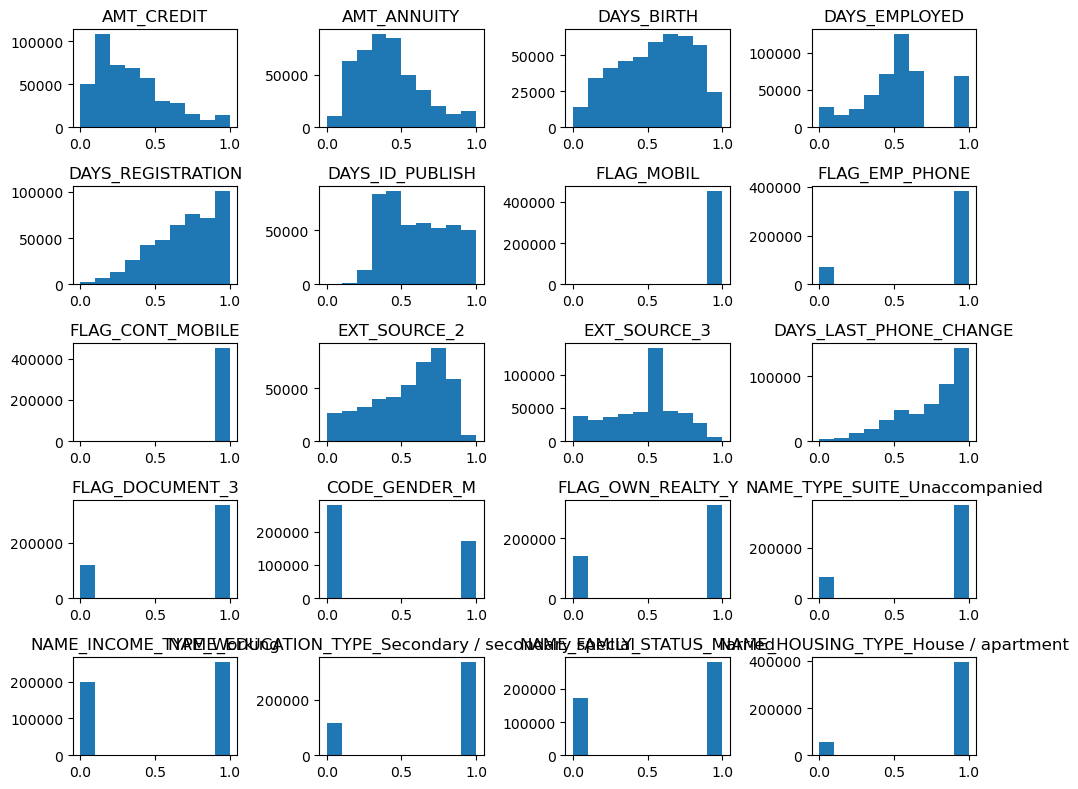

In [96]:
X_train_new_scaled.hist(figsize=(10,8), grid=False)
plt.tight_layout()

### Modeling

**Logistic Regression**

In [97]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train_new_scaled, y_train)

LogisticRegression()

In [98]:
y_pred = logreg_model.predict(X_test_new_scaled)

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67     56326
           1       0.68      0.66      0.67     56749

    accuracy                           0.67    113075
   macro avg       0.67      0.67      0.67    113075
weighted avg       0.67      0.67      0.67    113075



<Axes: >

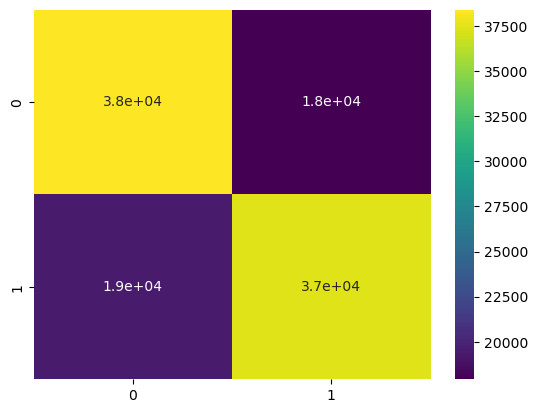

In [100]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='viridis', cbar=True)

In [101]:
score_acc =cross_val_score(estimator=LogisticRegression(),X=X_train_new_scaled, y=y_train, cv=5, scoring='accuracy')
print(score_acc)
print(score_acc.mean())

[0.668826   0.66789741 0.67182923 0.67242618 0.67530041]
0.6712558469065242


In [102]:
score_auc =cross_val_score(estimator=LogisticRegression(),X=X_train_new_scaled, y=y_train, cv=5, scoring='roc_auc')
print(score_auc)
print(score_auc.mean())

[0.72977202 0.72871265 0.73380717 0.73032463 0.73206037]
0.7309353671073069


**XGBoost**

In [103]:
xgb = XGBClassifier(learning_rate=0.1,max_depth=10,n_estimators=50) #objective='binary:logistic',

In [104]:
xgb.fit(X_train_new_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [105]:
y_pred = xgb.predict(X_test_new_scaled)

In [106]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78     56326
           1       0.77      0.81      0.79     56749

    accuracy                           0.79    113075
   macro avg       0.79      0.79      0.79    113075
weighted avg       0.79      0.79      0.79    113075



<Axes: >

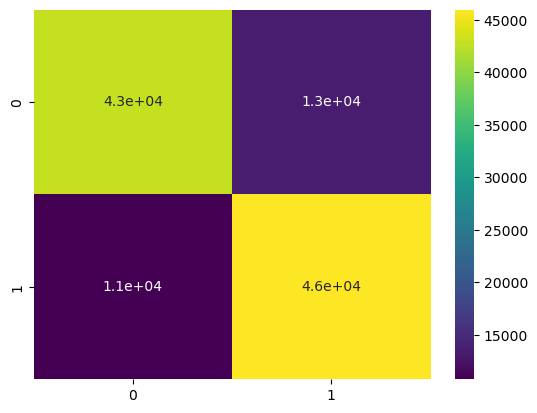

In [107]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='viridis', cbar=True)

In [108]:
score_acc =cross_val_score(xgb,X=X_train_new_scaled, y=y_train, cv=5, scoring='accuracy')
print(score_acc)
print(score_acc.mean())

[0.78415874 0.78371656 0.78417847 0.78564875 0.78613516]
0.7847675347388232


In [109]:
score_auc =cross_val_score(xgb,X=X_train_new_scaled, y=y_train, cv=5, scoring='roc_auc')
print(score_auc)
print(score_auc.mean())

[0.86633804 0.86692824 0.86744715 0.86907674 0.86813926]
0.8675858852667309


**ADA Boost**

In [ ]:
#from sklearn.ensemble import AdaBoostClassifier
#ada = AdaBoostClassifier(random_state=0,learning_rate=0.5,n_estimators=50)

In [ ]:
#ada.fit(X_train_new_scaled, y_train)

In [ ]:
#y_pred = ada.predict(X_test_new_scaled)

In [ ]:
#print(classification_report(y_test, y_pred))

In [ ]:
#cm = confusion_matrix(y_test, y_pred)
#sns.heatmap(cm, annot=True, cmap='viridis', cbar=True)

In [ ]:
#score_acc =cross_val_score(ada,X=X_train_new_scaled, y=y_train, cv=5, scoring='accuracy')
#print(score_acc)
#print(score_acc.mean())

In [ ]:
#score_auc =cross_val_score(ada,X=X_train_new_scaled, y=y_train, cv=5, scoring='roc_auc')
#print(score_auc)
#print(score_auc.mean())

**Gradient Boosting**

In [ ]:
#from sklearn.ensemble import GradientBoostingClassifier
#gb = GradientBoostingClassifier(random_state=0)

In [ ]:
#param_gb = {
#        'learning_rate': [0.1, 0.3, 0.5],
#        'n_estimators': [10, 20, 30, 50]
#    }
#param_gb

In [ ]:
#model_gb = GridSearchCV(
#    gb,
#    param_grid= param_gb,
#    cv=5,
#    n_jobs=-1,
#    verbose= 1
#)

In [ ]:
#model_gb.fit(X_train_new_scaled, y_train)

In [ ]:
#cv_results = pd.DataFrame(model_gb.cv_results_)
#cv_results.sort_values('rank_test_score').head(5)

In [ ]:
#model_gb.best_params_

In [ ]:
#y_pred = model_gb.predict(X_test_new_scaled)

In [ ]:
#print(classification_report(y_test, y_pred))

In [ ]:
#cm = confusion_matrix(y_test, y_pred)
#sns.heatmap(cm, annot=True, cmap='viridis', cbar=True)

In [ ]:
#score_acc =cross_val_score(model_gb,X=X_train_new_scaled, y=y_train, cv=5, scoring='accuracy')
#print(score_acc)
#print(score_acc.mean())

**Random Forest**

In [110]:
rf_model = RandomForestClassifier(random_state=0)

In [111]:
params= {
    "n_estimators":range(5 , 30 , 5),
    "max_depth": range(5 , 30 , 5)
}

params

{'n_estimators': range(5, 30, 5), 'max_depth': range(5, 30, 5)}

In [112]:
model = GridSearchCV(
    rf_model,
    param_grid= params,
    cv=5,
    n_jobs=-1,
    verbose= 1
)

In [114]:
model.fit(X_train_new_scaled, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': range(5, 30, 5),
                         'n_estimators': range(5, 30, 5)},
             verbose=1)

In [115]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
24,38.672462,3.228999,0.757471,0.063813,25,25,"{'max_depth': 25, 'n_estimators': 25}",0.978609,0.978488,0.979317,0.979084,0.979084,0.978917,0.000315,1
23,36.740519,0.850376,1.026121,0.230343,25,20,"{'max_depth': 25, 'n_estimators': 20}",0.977581,0.977570,0.978874,0.978808,0.978112,0.978189,0.000568,2
22,28.380418,0.776437,1.110915,0.042354,25,15,"{'max_depth': 25, 'n_estimators': 15}",0.974740,0.974132,0.976144,0.975779,0.974795,0.975118,0.000736,3
21,19.134101,0.631633,0.756416,0.063282,25,10,"{'max_depth': 25, 'n_estimators': 10}",0.974077,0.973502,0.975613,0.975094,0.974032,0.974464,0.000772,4
20,9.957107,0.579935,0.398414,0.025467,25,5,"{'max_depth': 25, 'n_estimators': 5}",0.957351,0.956213,0.957594,0.956809,0.956444,0.956882,0.000524,5


In [116]:
model.best_params_

{'max_depth': 25, 'n_estimators': 25}

In [117]:
y_pred = model.predict(X_test_new_scaled)

In [118]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56326
           1       0.97      1.00      0.98     56749

    accuracy                           0.98    113075
   macro avg       0.98      0.98      0.98    113075
weighted avg       0.98      0.98      0.98    113075



<Axes: >

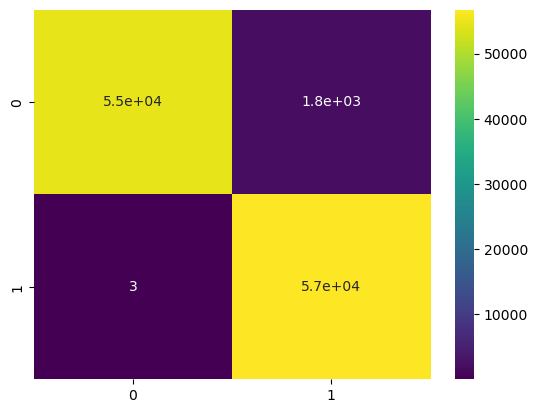

In [119]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='viridis', cbar=True)

**Decision Tree**

In [ ]:
#from sklearn.tree import DecisionTreeClassifier
#dt = DecisionTreeClassifier(random_state= 0)

In [ ]:
#param_dt = {
#    'criterion': ['gini', 'entropy', 'log_loss'],
#    'max_depth':[10,20,30]
#}
#param_dt

In [ ]:
#model_dt = GridSearchCV(
#    dt,
#    param_grid= param_dt,
#    cv=5,
#    n_jobs=-1,
#    verbose= 1
#)

In [ ]:
#model_dt.fit(X_train_new_scaled, y_train)

In [ ]:
#cv_results = pd.DataFrame(model_dt.cv_results_)
#cv_results.sort_values('rank_test_score').head(5)

In [ ]:
#model_dt.best_params_

In [ ]:
#y_pred = model_dt.predict(X_test_new_scaled)

In [ ]:
#print(classification_report(y_test, y_pred))

In [ ]:
#cm = confusion_matrix(y_test, y_pred)
#sns.heatmap(cm, annot=True, cmap='viridis', cbar=True)

**SVM**

In [ ]:
#from sklearn.svm import SVC
#svm = SVC(kernel = 'rbf',random_state = 0, probability=True)

In [ ]:
#params_svm= {
#    'kernel': ['linear', 'rbf', 'sigmoid']
#}

#params_svm

In [ ]:
#model_svm= GridSearchCV(
#    svm,
#    param_grid= params_svm,
#    cv=5,
#    n_jobs=-1,
#    verbose= 1
#)

In [ ]:
#svm.fit(X_train_new_scaled, y_train)

In [ ]:
#cv_results = pd.DataFrame(svm.cv_results_)
#cv_results.sort_values('rank_test_score').head(5)

In [ ]:
#model_svm.best_params_

In [ ]:
#y_pred = svm.predict(X_test_new_scaled)

In [ ]:
#print(classification_report(y_test, y_pred))

In [ ]:
#cm = confusion_matrix(y_test, y_pred)
#sns.heatmap(cm, annot=True, cmap='viridis', cbar=True)

In [ ]:
#score_acc =cross_val_score(svm,X=X_train_new_scaled, y=y_train, cv=3, scoring='accuracy')
#print(score_acc)
#print(score_acc.mean())

In [ ]:
#score_auc =cross_val_score(svm,X=X_train_new_scaled, y=y_train, cv=3, scoring='roc_auc')
#print(score_auc)
#print(score_auc.mean())

### Prediction

In [120]:
import pickle

In [121]:
pickle.dump(xgb, open('model_xgboost_hci.pkl', 'wb'))

In [122]:
best_model = pickle.load(open('model_xgboost_hci.pkl', 'rb'))

In [123]:
# Mencoba melakukan prediksi data_test
prediksi = best_model.predict(data_test_new_scaled)
#prediksi = best_model.predict(test_cols)

In [124]:
data_test_new_scaled.insert(0, "PRED_TARGET", prediksi, True)
data_test_new_scaled.head()

,PRED_TARGET,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,CODE_GENDER_M,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_HOUSING_TYPE_House / apartment
0,0,0.333286,0.315285,0.337542,0.418606,0.670359,0.887175,1.0,1.0,1.0,0.923573,0.088305,0.504838,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
1,1,0.113111,0.262188,0.403890,0.202094,0.418634,0.774489,1.0,1.0,1.0,0.341118,0.426797,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0,0.393392,1.134352,0.292616,0.203207,0.861321,0.513269,1.0,1.0,1.0,0.818464,0.647178,0.756403,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
3,0,0.973515,0.788886,0.634329,0.465449,0.872479,0.415312,1.0,1.0,1.0,0.596114,0.649299,0.486340,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1,0.369363,0.506778,0.687091,0.432568,0.744959,0.407809,1.0,1.0,1.0,0.497880,NaN,0.766363,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [125]:
# Merubah dalam format DataFrame
hasil_prediksi=pd.concat([test_id,data_test_new_scaled],axis=1)
hasil_prediksi.head(5)

#test_cols.insert(2, "TARGET", prediksi, True)
#test_cols.head(10)

,SK_ID_CURR,PRED_TARGET,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,CODE_GENDER_M,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_HOUSING_TYPE_House / apartment
0,100001,0,0.333286,0.315285,0.337542,0.418606,0.670359,0.887175,1.0,1.0,1.0,0.923573,0.088305,0.504838,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
1,100005,1,0.113111,0.262188,0.403890,0.202094,0.418634,0.774489,1.0,1.0,1.0,0.341118,0.426797,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,100013,0,0.393392,1.134352,0.292616,0.203207,0.861321,0.513269,1.0,1.0,1.0,0.818464,0.647178,0.756403,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
3,100028,0,0.973515,0.788886,0.634329,0.465449,0.872479,0.415312,1.0,1.0,1.0,0.596114,0.649299,0.486340,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
4,100038,1,0.369363,0.506778,0.687091,0.432568,0.744959,0.407809,1.0,1.0,1.0,0.497880,NaN,0.766363,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [126]:
hasil_prediksi.to_csv('prediksi_xgboost_hci.csv')

In [ ]:
#test_cols.to_csv('prediksi_xgboost_hci.csv')